In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)  # FutureWarningを消している

In [2]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt

In [3]:
# 渋谷駅（スクランブル交差点）
shibuya_eki = 35.65952515598417, 139.70055390184527
# HENGE
henge = 35.65495728145334, 139.69494603459512


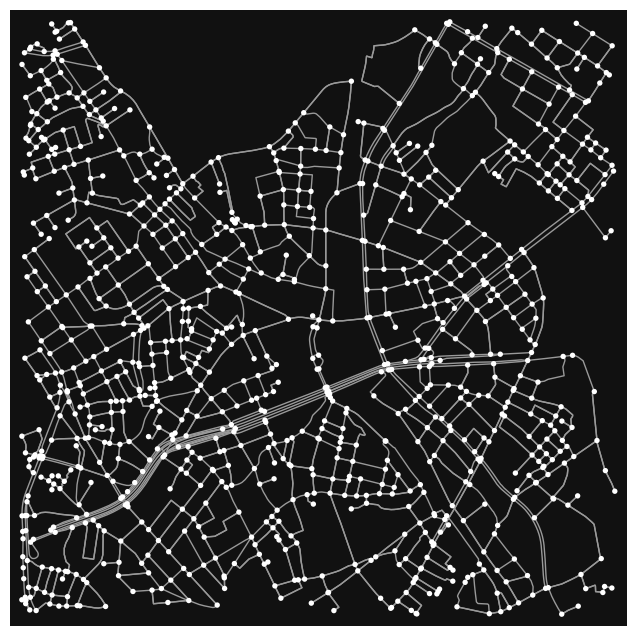

In [4]:
# 渋谷駅を中心とした半径1000mの地図を表示
dist = 1000  # meters
G = ox.graph_from_point(shibuya_eki, dist, network_type="drive")
fig, ax = ox.plot_graph(G)

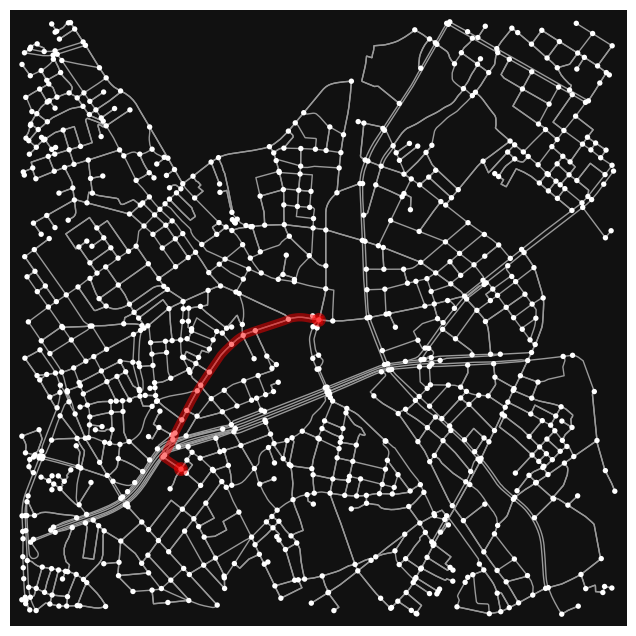

In [5]:
# 渋谷駅からHENGEまでの最短距離
start_node = ox.distance.nearest_nodes(G, shibuya_eki[1], shibuya_eki[0])
end_node = ox.distance.nearest_nodes(G, henge[1], henge[0])

route1 = ox.shortest_path(G, start_node, end_node)  # 最短経路を取得
fig, ax = ox.plot_graph_route(G, route1, route_color='r', route_linewidth=6) # ルートを表示

In [6]:
# 神泉駅
shinsen = 35.65775285967325, 139.69353293448464

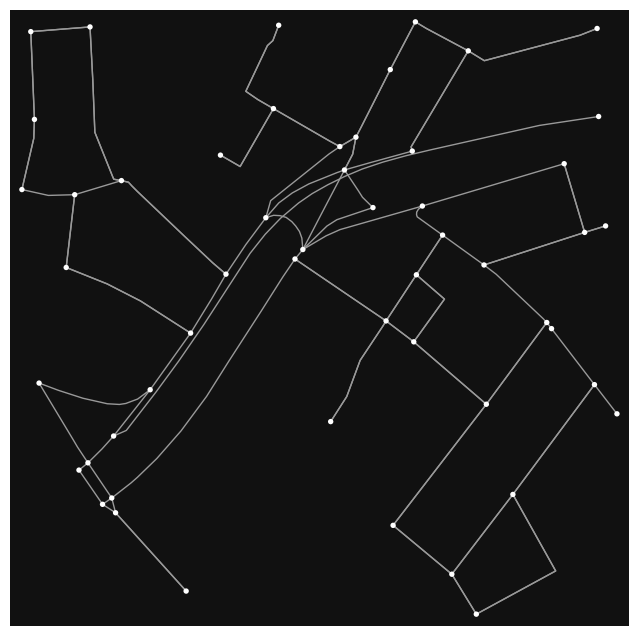

In [20]:
# HENGEを中心とした半径1000mの地図を表示
dist = 200  # meters
G = ox.graph_from_point(henge, dist, network_type="drive")
fig, ax = ox.plot_graph(G)

In [21]:
# ある地点からある地点までの最短ルートを取得
def get_shortest_routes(G, start1, start2, end1, end2):
    start_node = ox.distance.nearest_nodes(G, start1, start2)
    end_node = ox.distance.nearest_nodes(G, end1, end2)
    
    return ox.shortest_path(G, start_node, end_node)  # 最短経路を取得

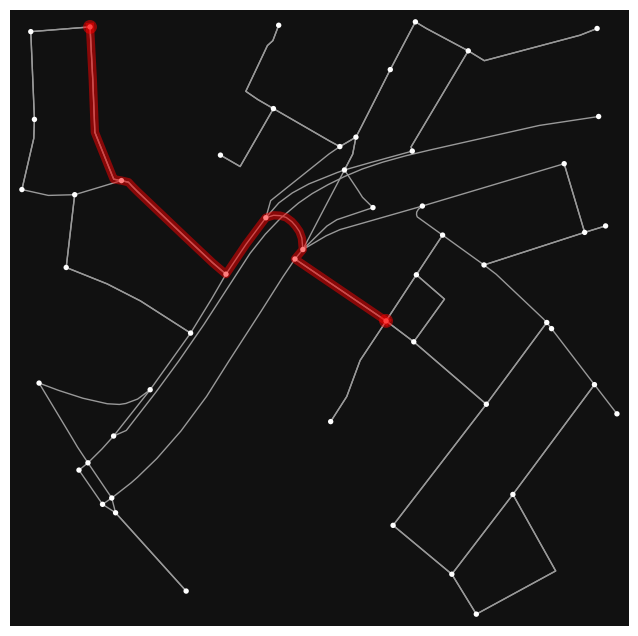

In [22]:
# 神泉駅からHENGEまでの最短距離
# start_node = ox.distance.nearest_nodes(G, shinsen[1], shinsen[0])
# end_node = ox.distance.nearest_nodes(G, henge[1], henge[0])

# route = ox.shortest_path(G, start_node, end_node)  # 最短経路を取得
route2 = get_shortest_routes(G, shinsen[1], shinsen[0], henge[1], henge[0])
fig, ax = ox.plot_graph_route(G, route2, route_color='r', route_linewidth=6) # ルートを表示

In [23]:
route2

[705961061, 330384175, 356645085, 1496233048, 625566390, 748883733, 748883764]

In [11]:
# # 道路グラフネットワークの各ノード・エッジ取得・CSV出力
# nodes, edges = ox.graph_to_gdfs(G)
# nodes.to_csv("road_network_nodes.csv")
# edges.to_csv("road_network_edges.csv")

In [12]:
import numpy as np

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    2点間の方位角（北から時計回りの角度）を計算する関数
    """
    # 緯度・経度をラジアンに変換
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # 経度の差
    delta_lon = lon2 - lon1

    # 方位角の計算
    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)

    # atan2で方位角を求める（ラジアン）
    bearing = np.degrees(np.arctan2(x, y))

    # 0から360度の範囲に調整
    bearing = (bearing + 360) % 360

    return bearing


In [34]:
new_route = [route2[0]]
tmp_route = route2[:]
print("tmp_route=", tmp_route)
print("len(tmp_route)=", len(tmp_route))

for i in range(1, len(tmp_route) - 1):
    print("================i=", i)
    lat1, lon1 = G.nodes[tmp_route[i -1]]['y'], G.nodes[tmp_route[i - 1]]['x']
    # print("lat1, lon1", lat1, lon1)
    lat2, lon2 = G.nodes[tmp_route[i]]['y'], G.nodes[tmp_route[i]]['x']
    # print("lat2, lon2", lat2, lon2)
    lat3, lon3 = G.nodes[tmp_route[i + 1]]['y'], G.nodes[tmp_route[i + 1]]['x']
    # print("lat3, lon3", lat3, lon3)

    bearing1 = calculate_bearing(lat1, lon1, lat2, lon2)
    bearing2 = calculate_bearing(lat2, lon2, lat3, lon3)
    bearing_diff = bearing2 - bearing1
    print("tmp_route[i]=", tmp_route[i])
    print("bearing_diff=", bearing_diff)

    # neighbors = list(G.neighbors(tmp_route[i]))  # 他の隣接するノードを調査
    neighbors = ox.nearest_nodes(G, lat2, lon2)
    print("neighbors=",neighbors)

    if bearing_diff > 45:
        # 右折
        print("i=", i, ": tmp_route[i]", tmp_route[i])
        # neighbors = list(G.neighbors(tmp_route[i]))  # 他の隣接するノードを調査
        # try:
        #     neighbors.remove(tmp_route[i - 1])
        #     neighbors.remove(tmp_route[i + 1])
        # except:
        #     pass
        # print("neighbors=",neighbors)
        if not neighbors or len(neighbors) < 1 :
            # 来た道と元の進行方法しかない場合はあきらめる
            print("失敗")
            # ToDo. 失敗せずに1つ前のノードに戻って周りを検索するとなおよい。
            break
        else:
            # 他のノードで、90以下になるノードを探す
            # neighbors.remove(tmp_route[i - 1])
            # neighbors.remove(tmp_route[i + 1])
            # print("neighbors", neighbors)
            for j in range(0, len(neighbors)):
                lat3, lon3 = G.nodes[neighbors[j]]['y'], G.nodes[neighbors[j]]['x']
                bearing2 = calculate_bearing(lat2, lon2, lat3, lon3)
                bearing_diff = bearing2 - bearing1
                print("bearing_diff2=", bearing_diff)
                if bearing_diff > 45:
                    continue
                else:
                    new_route.append(tmp_route[i])
                    # 新しいノードからゴールまでの最短距離を求める
                    route_n = get_shortest_routes(G, lat3, lon3, henge[1], henge[0])
                    print("route_n=", route_n)
                    tmp_route = tmp_route[:i +1] + route_n[:]
                    print("tmp_route=", tmp_route)
                    # ToDo.
                    # 点Aから点Bまでの最短距離を求める関数を作って、ルートのリストを入れ替えながら、新しいルートを模索していく
                    break
    else:
        # それ以外
        new_route.append(tmp_route[i])
        print("new_route=", new_route)
        continue
new_route.append(route2[-1])
print("new_route=", new_route)

tmp_route= [705961061, 330384175, 356645085, 1496233048, 625566390, 748883733, 748883764]
len(tmp_route)= 7
================i= 1
tmp_route[i]= 330384175
bearing_diff= -36.62146057438281
neighbors= 381044679
new_route= [705961061, 330384175]
================i= 2
tmp_route[i]= 356645085
bearing_diff= -96.58912807648011
neighbors= 381044679
new_route= [705961061, 330384175, 356645085]
================i= 3
tmp_route[i]= 1496233048
bearing_diff= 95.40673946957241
neighbors= 381044679
i= 3 : tmp_route[i] 1496233048


TypeError: object of type 'int' has no len()

AttributeError: 'NoneType' object has no attribute 'values'

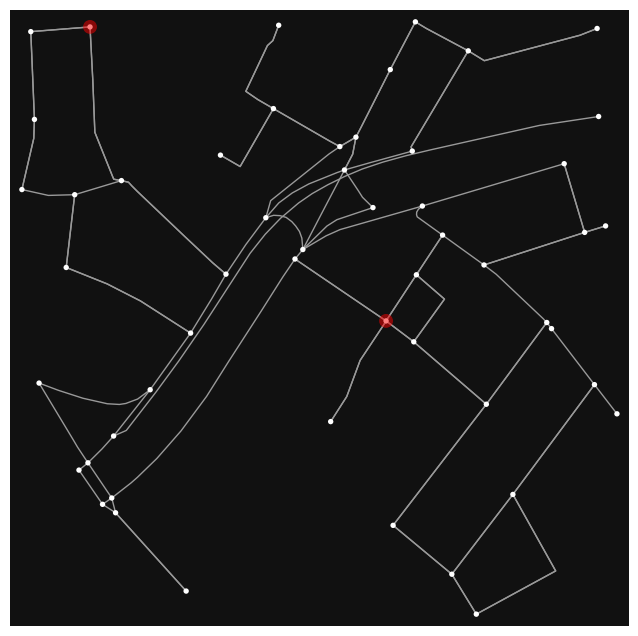

In [32]:
fig, ax = ox.plot_graph_route(G, new_route, route_color='r', route_linewidth=6) # ルートを表示

In [15]:
len(new_route)

13